# Online Learning Experiments - Group Project

This notebook contains all experiments for the Online Learning project, organized in a modular and scalable way.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Experiment Configuration Framework](#framework)
3. [Task 1.1: UCB1 Simple Pricing](#task1_1)
4. [Task 1.2: Constrained UCB Pricing](#task1_2)
5. [Task 2.1: Combinatorial UCB Multi-Product](#task2_1)
6. [Task 3.1: Primal-Dual Non-Stationary](#task3_1)
7. [Task 4.1: Multi-Product Primal-Dual](#task4_1)
8. [Task 5.1: Sliding Window Non-Stationarity](#task5_1)

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati")

Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

# Import custom modules
from environments import *
from agents import *
from data_generators import *
from utils import *
from runner import *
from plotter import *

# Configure plotting
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completed successfully!")


Experiment framework created successfully!
Plotting and analysis utilities created successfully!
Setup completed successfully!


## <a id="task1_1"></a>Task 1.1: UCB1 Simple Pricing

Implementation of UCB1 for the pricing problem with uniform valuations.

Task 1.1 - UCB1 Simple Pricing
Prices: [0.2   0.533 0.811 1.001]
Expected revenues: [ 0.16      0.248911  0.153279 -0.001001]
Best clairvoyant price: 0.533 (idx 1)
Running Task 1.1 - UCB1 Simple Pricing
Horizon: 10000, Trials: 3
Trial 1/3... ✓
Trial 2/3... ✓
Trial 3/3... ✓


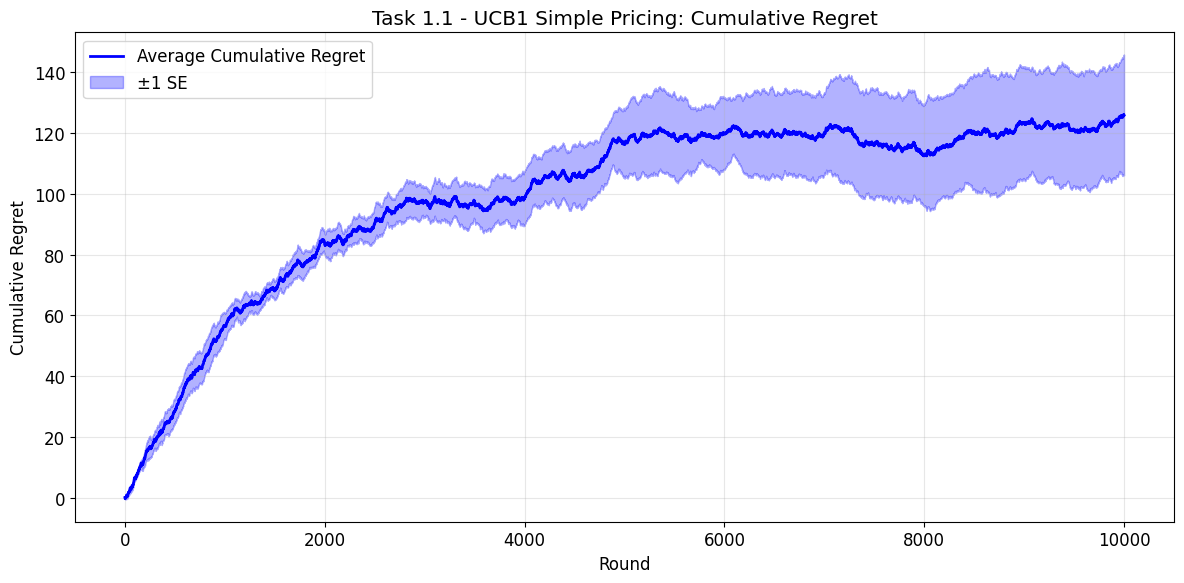

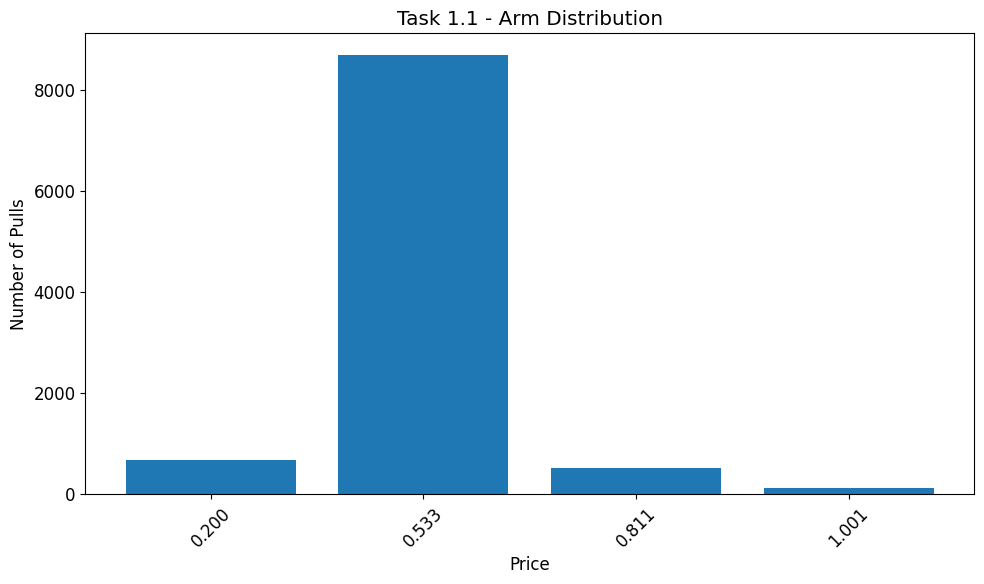

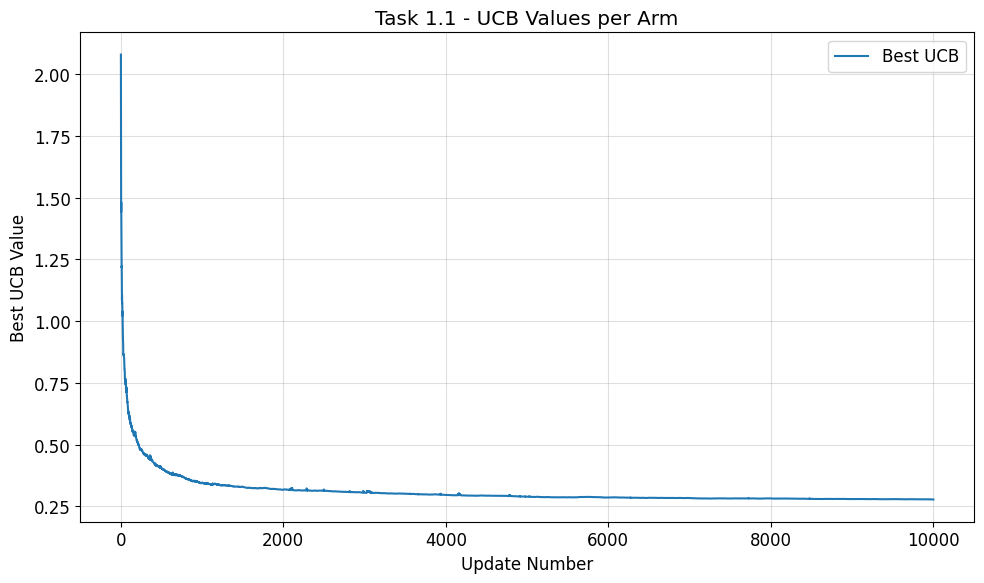


RESULTS FOR Task 1.1 - UCB1 Simple Pricing
Execution time: 0.55 seconds
Completed rounds: 10000
Average regret per round: 0.012586
Average final reward: 2363.25 ± 34.33
Efficiency vs clairvoyant: 94.9%

Detailed Results:
Expected revenues: [ 0.16    0.2489  0.1533 -0.001 ]
Empirical average rewards: [0.1619 0.2455 0.1439 0.    ]


In [13]:
class Task1_1_Runner(StandardExperimentRunner):
    """UCB1 Simple Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.expected_revenues = self.prices * (1 - self.prices)
        self.best_idx = np.argmax(self.expected_revenues)
        self.clairvoyant_reward_per_round = self.expected_revenues[self.best_idx]
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return PricingEnvironment(self.prices, self.config.horizon, rng=rng)
        
    def create_agent(self):
        return UCB1PricingAgent(len(self.prices), self.config.horizon)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clairvoyant_reward_per_round
        
    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result), 1.0

price_grid = create_simple_prices()
config = ExperimentConfig(
    task_name="Task 1.1 - UCB1 Simple Pricing",
    horizon=10_000,
    n_trials=3,
    seed=18,
    prices=price_grid
)

print(f"Task 1.1 - UCB1 Simple Pricing")
print(f"Prices: {price_grid}")

expected_revenues = price_grid * (1 - price_grid)
best_idx = np.argmax(expected_revenues)
best_price = price_grid[best_idx]

print(f"Expected revenues: {np.round(expected_revenues, 6)}")
print(f"Best clairvoyant price: {best_price} (idx {best_idx})")

# Run experiment
runner = Task1_1_Runner(config)
result: ExperimentResult = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=False)

StandardPlotter.plot_arm_distribution(result.final_agents[0], price_grid, "Task 1.1 - Arm Distribution")


analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

print(f"\nDetailed Results:")
print(f"Expected revenues: {np.round(expected_revenues, 4)}")
print(f"Empirical average rewards: {np.round(result.final_agents[0].average_rewards, 4)}")

# Store result for later comparison
task1_1_result = result


## <a id="task1_2"></a>Task 1.2: Constrained UCB Pricing

Implementation of Constrained UCB for pricing with budget constraints.


Task 1.2 - Constrained UCB Pricing
Prices: 16 prices from 0.200 to 0.980
Budget: 11000, Horizon: 10000
Sell probabilities (uniform): first 5 = [0.8   0.744 0.689 0.633 0.578]
Expected rewards: first 5 = [0.16     0.190464 0.214279 0.232311 0.243916]
Clairvoyant utility per round: 0.2495
Running Task 1.2 - Constrained UCB Pricing
Horizon: 10000, Trials: 1
Trial 1/1... ✓


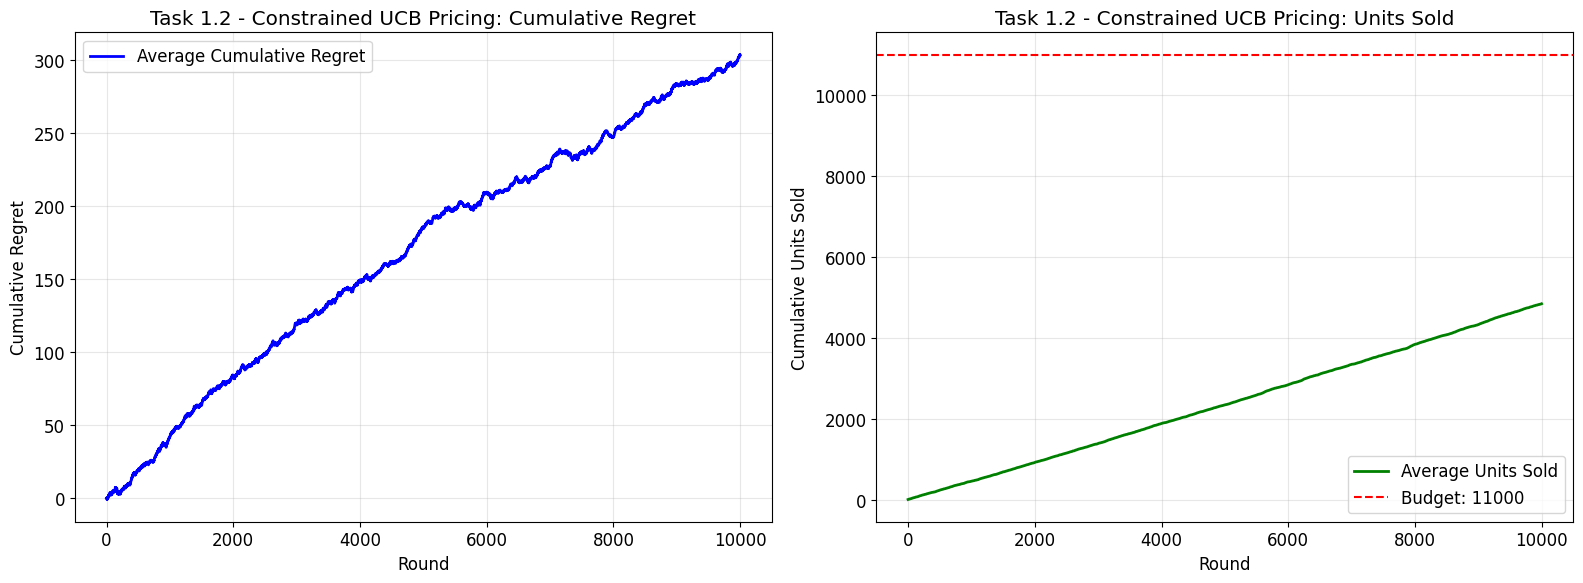

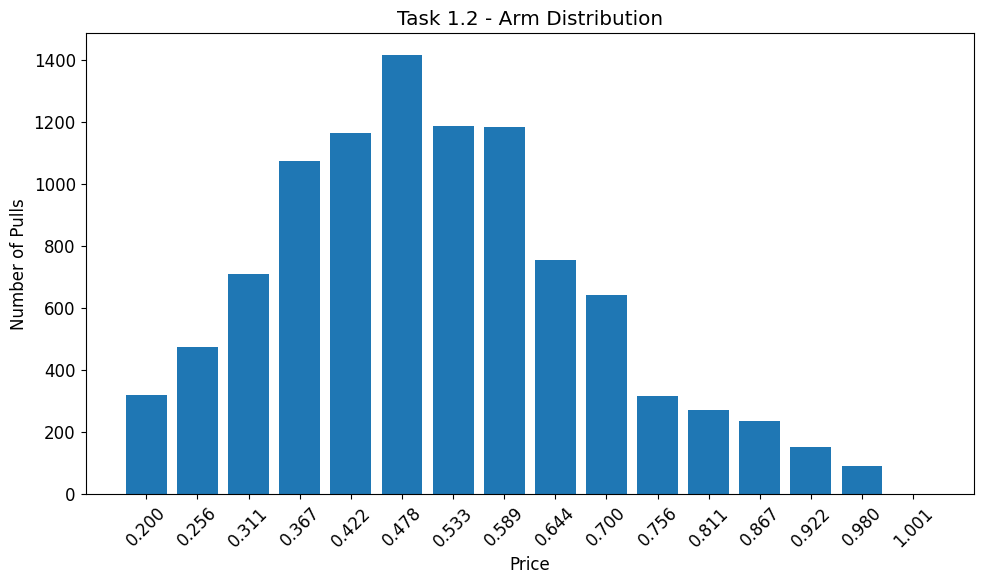

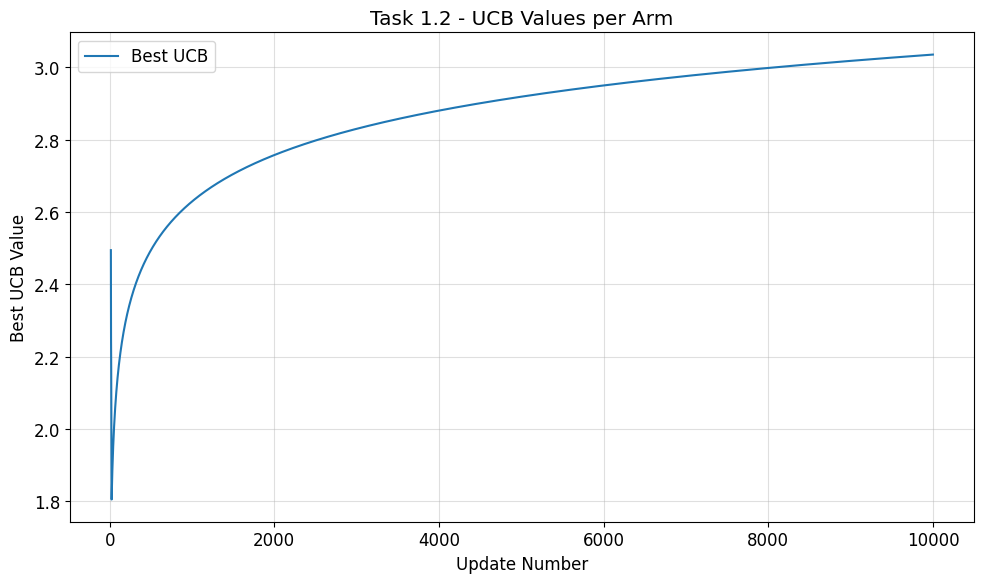


RESULTS FOR Task 1.2 - Constrained UCB Pricing
Execution time: 17.81 seconds
Completed rounds: 10000
Average regret per round: 0.030330
Average final reward: 2191.86 ± 0.00
Efficiency vs clairvoyant: 87.8%
Average units sold: 4838.00/11000 (44.0%)
Baseline reward: 2495.16


In [4]:
class Task1_2_Runner(StandardExperimentRunner):
    """Constrained UCB Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.sell_probabilities = np.maximum(0, 1 - self.prices)
        self.expected_reward = self.prices * self.sell_probabilities
        
        self.exp_util, self.gamma, self.exp_cost = compute_clairvoyant_single_product(
            self.prices, self.sell_probabilities, config.budget, config.horizon
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return BudgetedPricingEnvironment(self.prices, self.config.horizon, rng=rng)
        
    def create_agent(self):
        return ConstrainedUCBPricingAgent(len(self.prices), self.config.budget, self.config.horizon, alpha=1)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.exp_util
        
    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result[0]), float(result[1])

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 1.2 - Constrained UCB Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=11_000,
    prices=price_grid
)

print("Task 1.2 - Constrained UCB Pricing")
print(f"Prices: {len(price_grid)} prices from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

runner = Task1_2_Runner(config)

print(f"Sell probabilities (uniform): first 5 = {runner.sell_probabilities[:5]}")
print(f"Expected rewards: first 5 = {runner.expected_reward[:5]}")
print(f"Clairvoyant utility per round: {runner.exp_util:.4f}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

StandardPlotter.plot_arm_distribution(result.final_agents[0], price_grid, "Task 1.2 - Arm Distribution")


analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

baseline_reward = runner.exp_util * config.horizon
print(f"Baseline reward: {baseline_reward:.2f}")

task1_2_result = result


## <a id="task2_1"></a>Task 2.1: Combinatorial UCB Multi-Product

Implementation of Constrained Combinatorial UCB for multi-product pricing with shared budget.


Task 2.1 - Combinatorial UCB Multi-Product
Products: 3, Prices per product: 10
Budget: 11000, Horizon: 10000
Expected revenue per price (f_true): [array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ]), array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ]), array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ])]
Expected consumption per price (c_true): [array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ,
       0.        ]), array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ,
       0.        ]), array([1.        , 0.88888889, 0.777

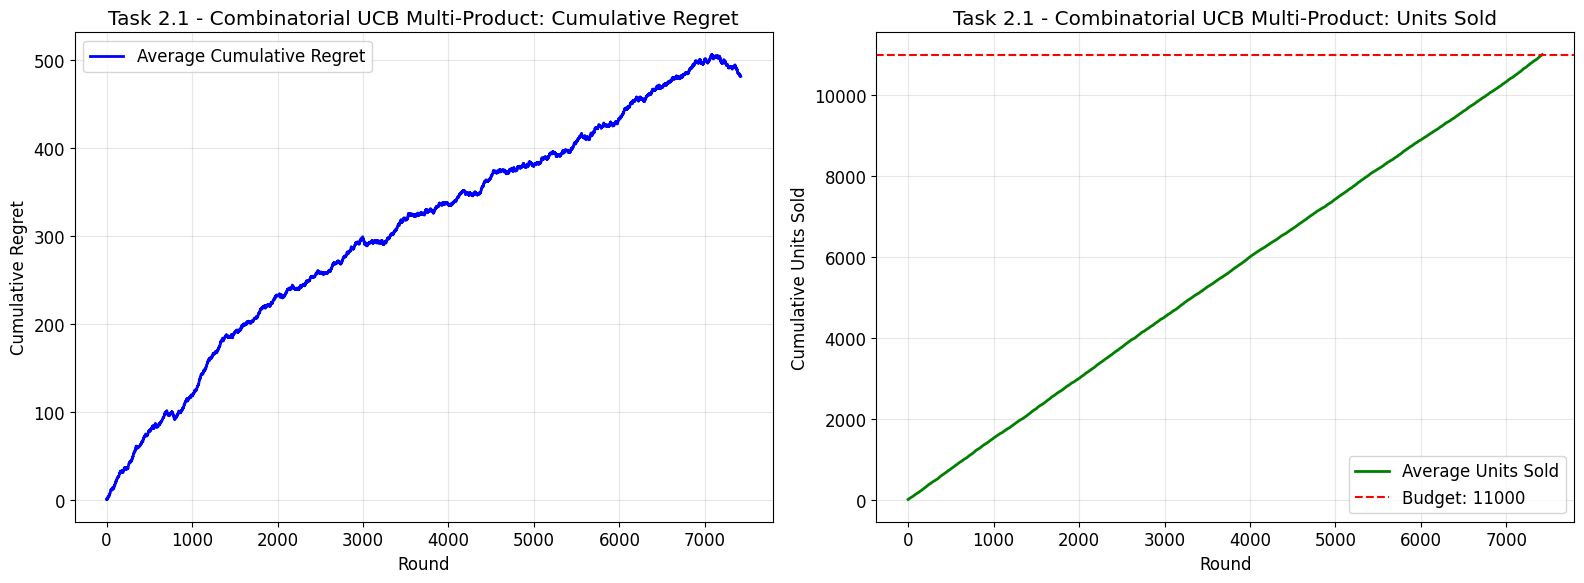

<Figure size 1000x600 with 0 Axes>

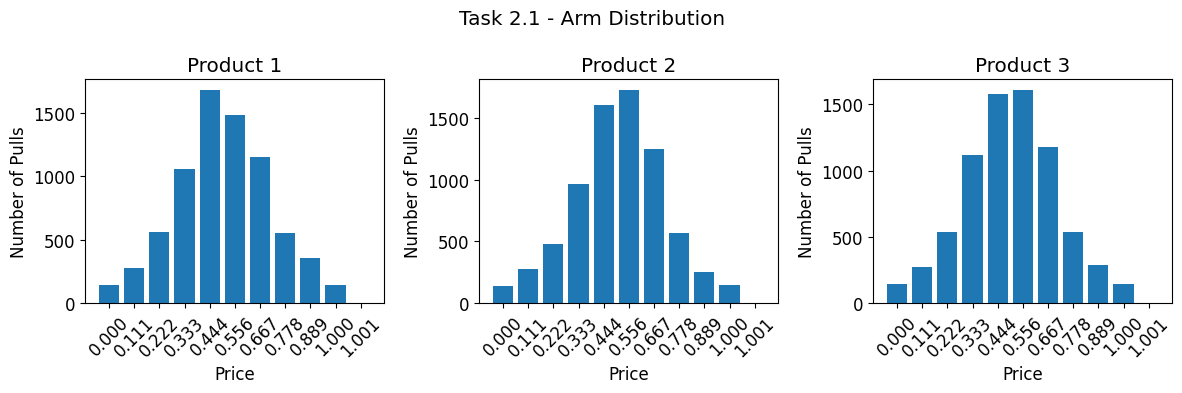


RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product
Execution time: 15.70 seconds
Completed rounds: 7421
Average regret per round: 0.064849
Average final reward: 4631.00 ± 0.00
Efficiency vs clairvoyant: 90.6%
Average units sold: 11000.00/11000 (100.0%)

Detailed Results Task 2.1:
Average regret per round: 0.0648
Average units sold: 11000.00
Budget utilization: 11000.0/11000 (100.0%)


In [5]:
class Task2_1_Runner(StandardExperimentRunner):
    """Combinatorial UCB Multi-Product experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [np.concatenate([config.prices, [1.001]]) for _ in range(self.n_products)]
        
        self.clair_reward, self.simplex = solve_clairvoyant_lp(self.price_grid, config.budget, config.horizon)
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return MultiProductPricingEnvironment(self.price_grid, self.config.horizon, rng=rng)
        
    def create_agent(self):
        return ConstrainedCombinatorialUCBAgent(self.price_grid, self.config.budget, self.config.horizon, alpha=2)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))

n_products = 3
price_grid = np.linspace(0, 1, 10)

config = ExperimentConfig(
    task_name="Task 2.1 - Combinatorial UCB Multi-Product",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=11_000,
    prices=price_grid,
    n_products=n_products
)

print(f"Task 2.1 - Combinatorial UCB Multi-Product")
print(f"Products: {n_products}, Prices per product: {len(price_grid)}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

# Run experiment
runner = Task2_1_Runner(config)

print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex solution shape: {np.array(runner.simplex).shape}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

StandardPlotter.plot_arm_distribution(result.final_agents[0], runner.price_grid, "Task 2.1 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

print(f"\nDetailed Results Task 2.1:")
if analysis['min_rounds'] > 0:
    print(f"Average regret per round: {analysis['avg_regret_per_round']:.4f}")
    final_units = [units[-1] if units else 0 for units in result.units_sold]
    avg_units = np.mean(final_units)
    print(f"Average units sold: {avg_units:.2f}")
    print(f"Budget utilization: {avg_units}/{config.budget} ({100*avg_units/config.budget:.1f}%)")

task2_1_result = result


## <a id="task3_1"></a>Task 3.1: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


Task 3.1 - Primal-Dual Non-Stationary Pricing
Budget: 6000, Horizon: 10000
Shock probability: 0.5, Frequency: 300
Prices: 16 from 0.200 to 0.980
Running Task 3.1 - Primal-Dual Non-Stationary Pricing
Horizon: 10000, Trials: 1
Trial 1/1... Clairvoyant utility: 0.2671
Expected cost per round: 0.6000
Sell probabilities (first 5): [0.8812 0.8292 0.7791 0.7135 0.6396]
Trial 1: Final reward = 2476.05, Budget remaining = 398
Final pull counts: [  49   94  269 1101 3034 3403 1029  369  173  123   88   70   42   51
   47   58]
Final λ multiplier: 0.0480 ✓


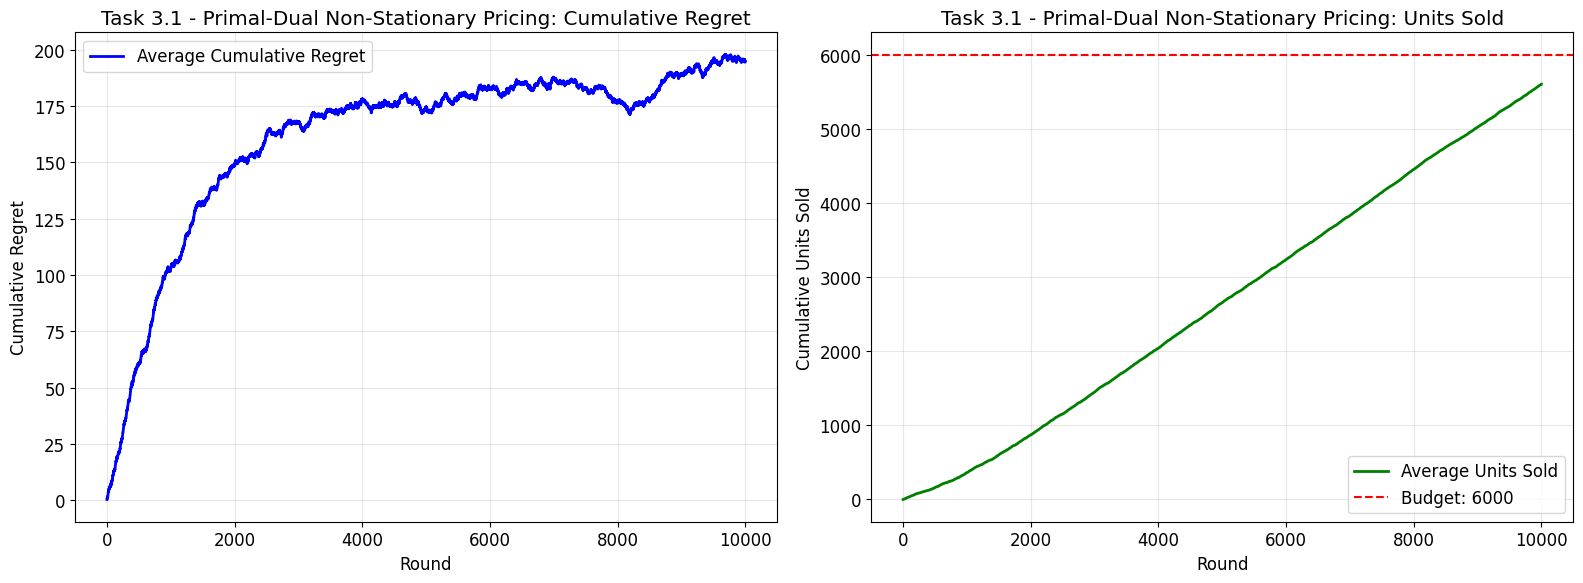

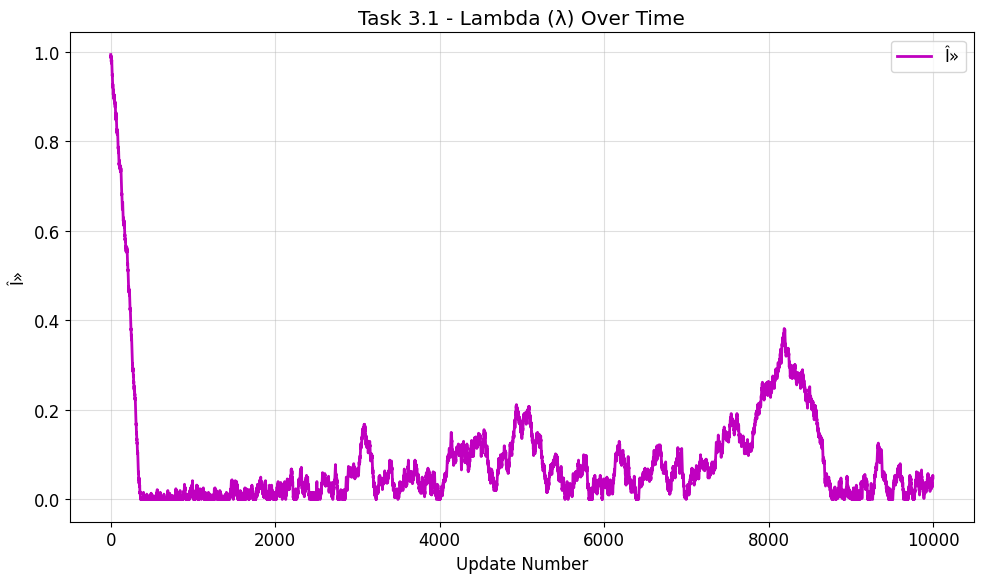

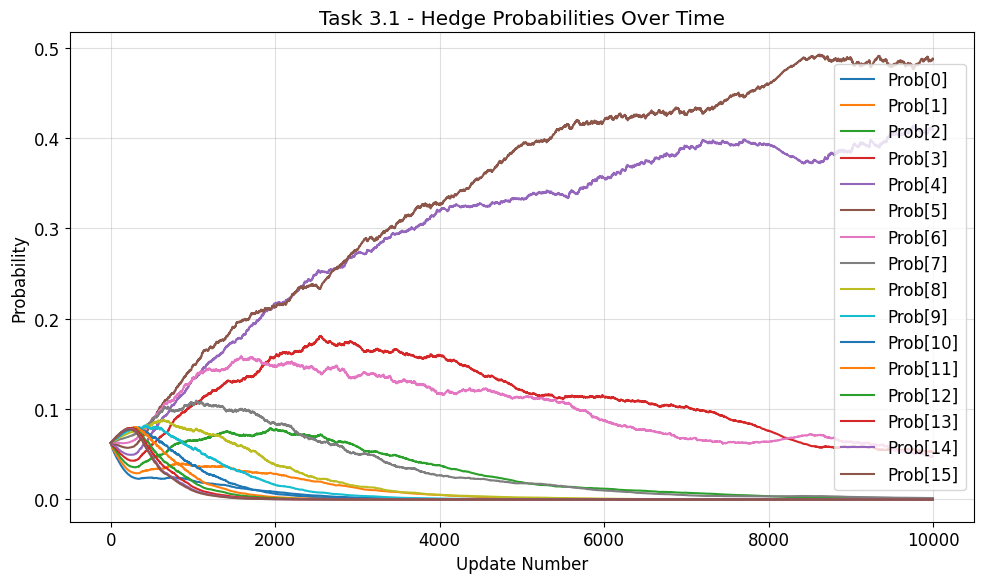


RESULTS FOR Task 3.1 - Primal-Dual Non-Stationary Pricing
Execution time: 0.46 seconds
Completed rounds: 10000
Average regret per round: 0.019477
Average final reward: 2476.05 ± 0.00
Average units sold: 5602.00/6000 (93.4%)


In [11]:
class Task3_1_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.0
        self.freq = 100
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq, 
            num_regimes=10000, valuation_type='beta', rng=rng
        )
        
    def create_agent(self):
        eta = 1 / np.sqrt(self.config.horizon)
        return FFPrimalDualPricingAgent(self.prices, self.config.horizon, self.config.budget, eta=eta)

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        return 0 # We override the run_single_trial method

        
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 3.1 due to special full-feedback structure"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        sell_probabilities = env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )
        
        if trial == 0:
            print(f"Clairvoyant utility: {exp_util:.4f}")
            print(f"Expected cost per round: {exp_cost:.4f}")
            print(f"Sell probabilities (first 5): {sell_probabilities[:5]}")
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        for t in range(self.config.horizon):
            arm = agent.pull_arm()
            if arm is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            valuation = env.round()
            reward, sold = agent.update(valuation)
            
            cum_reward += reward
            instant_regret = exp_util - reward
            cum_regret += instant_regret
            cum_units += sold
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))
            
        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}, Budget remaining = {agent.inventory}")
        print(f"Final pull counts: {agent.pull_counts}")
        print(f"Final λ multiplier: {agent.lmbd:.4f}", end=" ")
        
        return regrets, units_sold, cum_reward, agent

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.1 - Primal-Dual Non-Stationary Pricing",
    horizon=10_000,
    n_trials=1,
    seed=17,
    budget=6_000,
    prices=price_grid
)

print(f"Task 3.1 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(price_grid)} from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")

runner = Task3_1_Runner(config)
result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

StandardPlotter.plot_lambda(result.final_agents[0], title="Task 3.1 - Lambda (λ) Over Time")
StandardPlotter.plot_hedge_probabilities(result.final_agents[0], title="Task 3.1 - Hedge Probabilities Over Time")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task3_1_result = result


## Task 4.1: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.


Task 4.1 - Multi-Product Primal-Dual
Products: 4, Budget: 8000, Horizon: 10000
Prices: 16 from 0.200 to 0.980
Correlation parameters: μ₀=0.5, ρ₀=0.6
Running Task 4.1 - Multi-Product Primal-Dual
Horizon: 10000, Trials: 1
Trial 1/1... Clairvoyant reward per round: 0.4649
Expected cost per round: 0.8000
Optimal gamma shape: (4, 17)
Average gamma per product: [0.05882353 0.05882353 0.05882353 0.05882353] Trial 1: Final cumulative reward = 3972.64
Trial 1: Budget remaining = 319
Trial 1: Final λ = 0.0060
✓


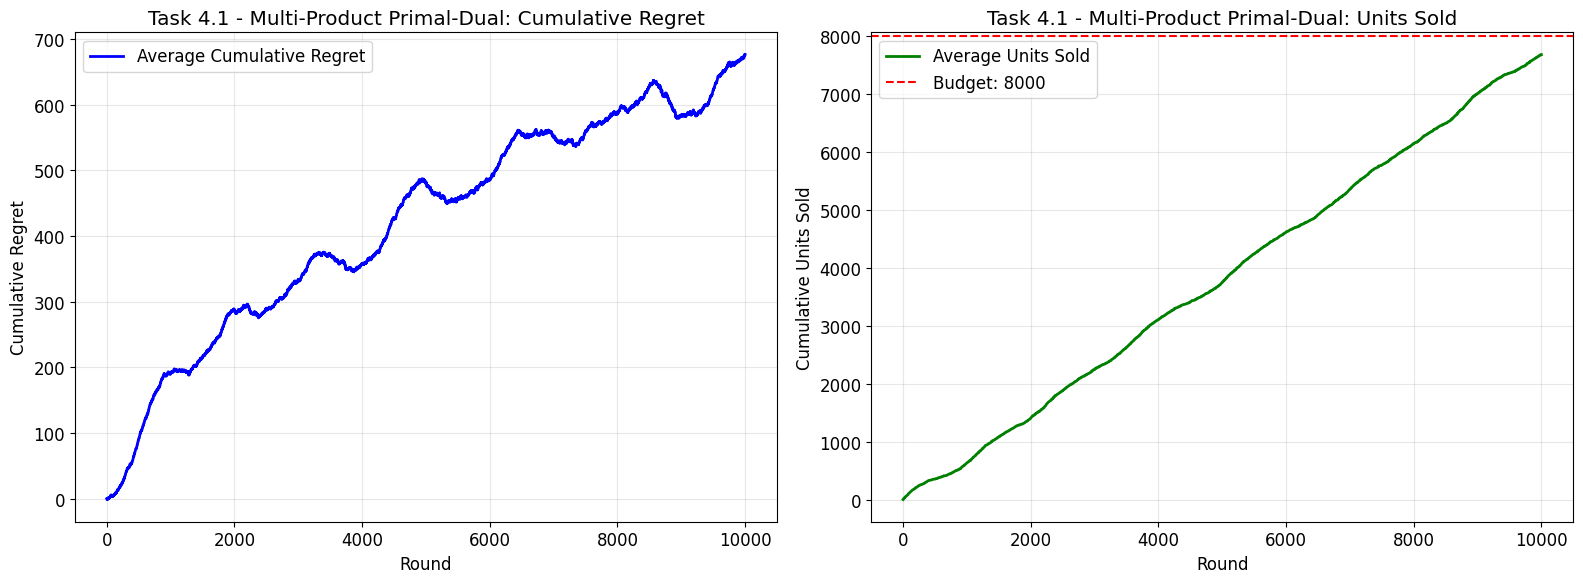

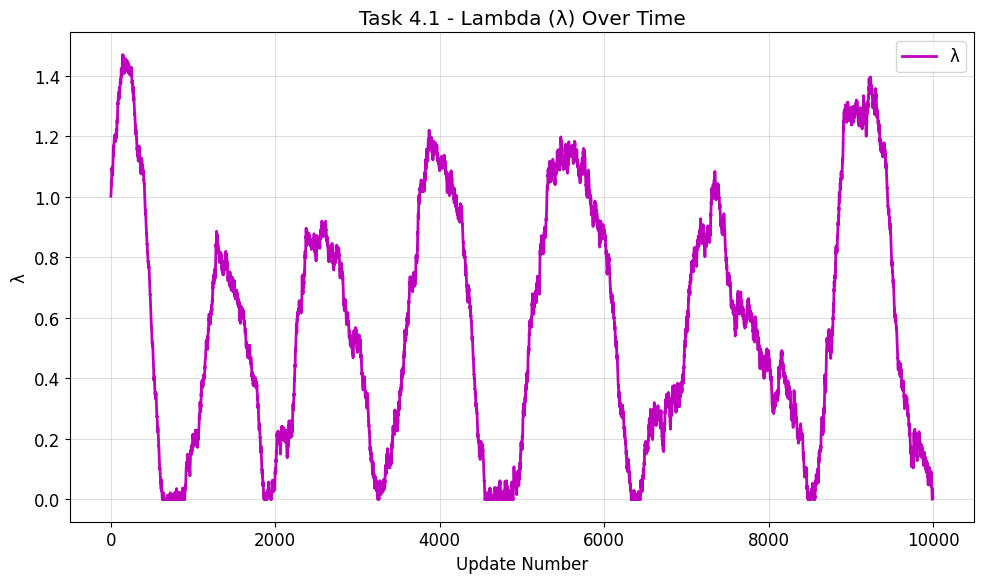

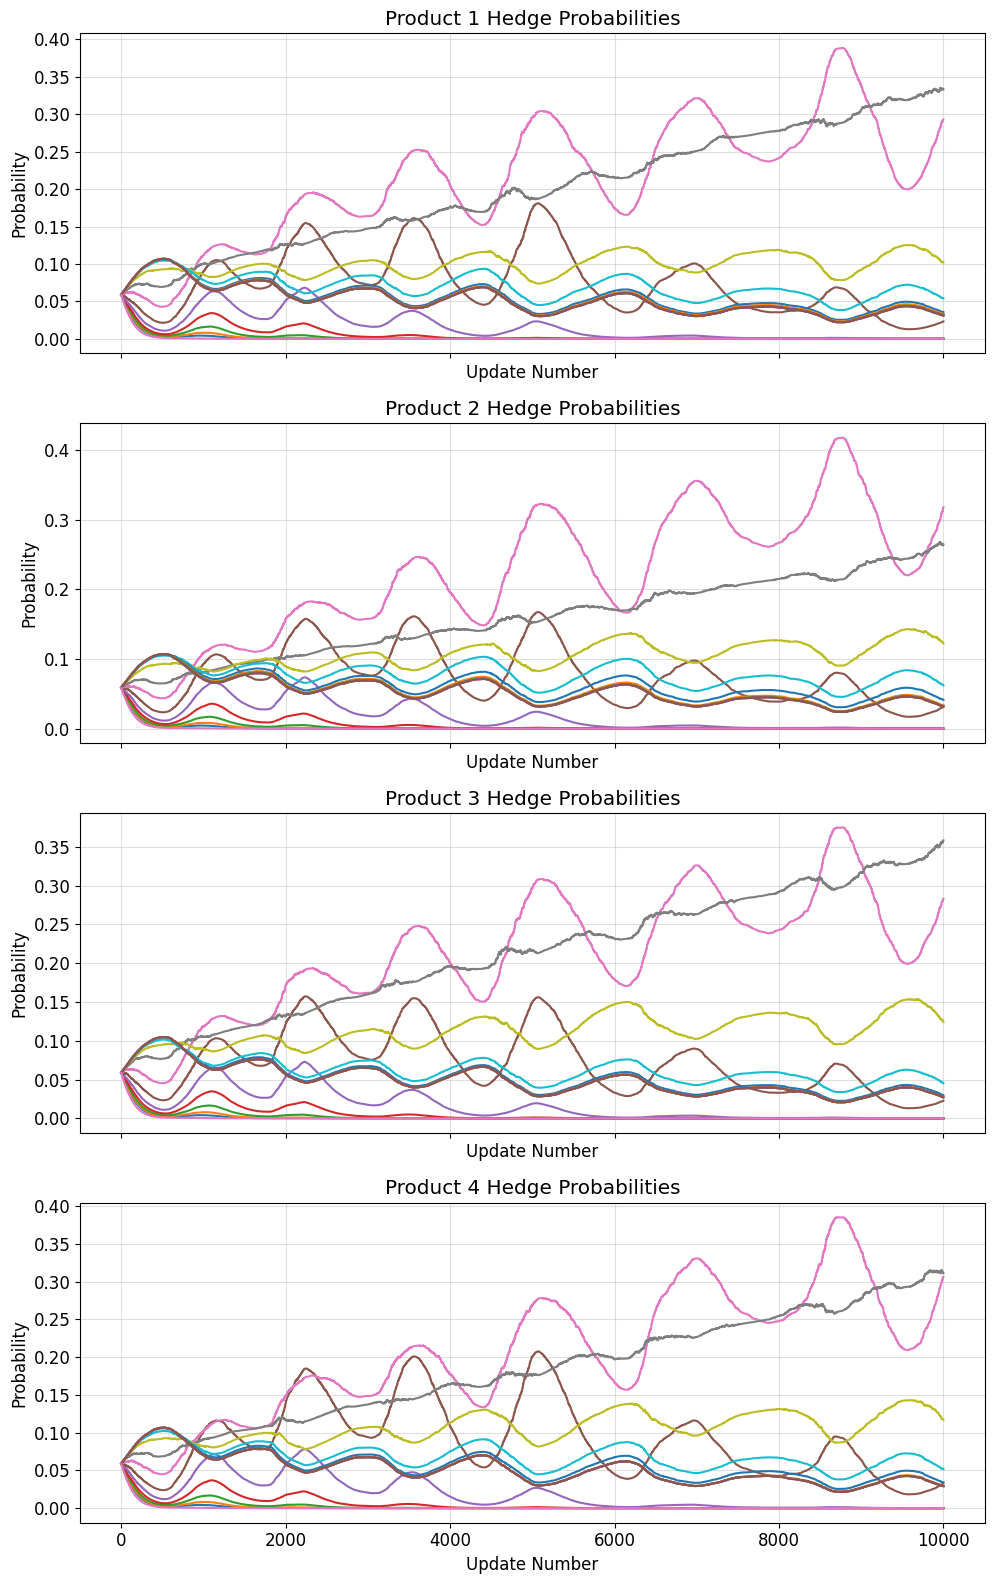


RESULTS FOR Task 4.1 - Multi-Product Primal-Dual
Execution time: 3.92 seconds
Completed rounds: 10000
Average regret per round: 0.067637
Average final reward: 3972.64 ± 0.00
Average units sold: 7681.00/8000 (96.0%)


In [8]:
class Task4_1_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        

        self.phi = 0.0
        self.mu0, self.A, self.f = 0.5, 0.1, 1000
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': 10000
        }
        return MultiProductBudgetedPricingEnvironment(
            self.price_grid, self.config.horizon, self.n_products, valuation_params, valuation_type='piecewise_tv', rng=rng
        )

    def create_agent(self) -> MultiProductFFPrimalDualPricingAgent:
        eta = 1 / np.sqrt(self.config.horizon)
        return MultiProductFFPrimalDualPricingAgent(self.price_grid, self.config.horizon, self.config.budget, self.n_products, eta)

    def compute_clairvoyant_reward(self) -> float:
        return 0  # We override the run_single_trial method

    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 4.1 due to special full-feedback multi-product structure"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        trial_rng = np.random.default_rng(trial_seed)

        V, _ = generate_piecewise_tv_mv_gauss(
            self.config.horizon, self.n_products, num_regimes=10000, rng=trial_rng)
        
        V, _ = generate_simple_tv_mv_gauss(
            self.config.horizon,
            self.n_products,
            mu0=self.mu0,
            A=self.A,
            f=self.f,
            phi=self.phi,
            sigma0=self.sigma0,
            A_sigma=self.A_sigma,
            phi_sigma=self.phi_sigma,
            rho0=self.rho0,
            rng=trial_rng
        )
        V, _ = generate_stationary_correlated_gauss(
    self.config.horizon, 
    self.n_products, 
    mu=0.5, 
    sigma=0.1, 
    rho=0.6,
    rng=trial_rng
)
        # TODO lambda do not converge 
        
                    

        exp_util, gamma, exp_cost = compute_extended_clairvoyant(
            V, self.price_grid[0], self.config.budget)

        if trial == 0:
            print(f"Clairvoyant reward per round: {exp_util:.4f}")
            print(f"Expected cost per round: {exp_cost:.4f}")
            print(f"Optimal gamma shape: {gamma.shape}")
            print(f"Average gamma per product: {gamma.mean(axis=1)}", end=" ")

        env = self.create_environment(trial_seed)
        env.V = V

        agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0

        for t in range(self.config.horizon):
            if agent.B < 1:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break

            v_t = env.round()
            reward, sold = agent.update(v_t)

            cum_reward += reward
            instant_regret = exp_util - reward
            cum_regret += instant_regret
            cum_units += sold
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final cumulative reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget remaining = {agent.B}")
        print(f"Trial {trial+1}: Final λ = {agent.lmbd:.4f}")

        return regrets, units_sold, cum_reward, agent


prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.1 - Multi-Product Primal-Dual",
    horizon=10_000,
    n_trials=1,
    seed=42,
    budget=8_000,
    prices=prices,
    n_products=4
)

print(f"Task 4.1 - Multi-Product Primal-Dual")
print(f"Products: 4, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print(f"Correlation parameters: μ₀=0.5, ρ₀=0.6")

runner = Task4_1_Runner(config)
result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)
StandardPlotter.plot_lambda(result.final_agents[0], title="Task 4.1 - Lambda (λ) Over Time")
StandardPlotter.plot_multi_hedge_probabilities(result.final_agents[0], 
    title="Task 4.1 - Multi-Product Hedge Probabilities Over Time")


analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task4_1_result = result

## Task 5.1: Sliding Window per Non-Stazionarietà

Implementazione di Constrained Combinatorial UCB con Sliding Window per adattamento locale a cambiamenti.


In [ ]:
class Task5_1_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int((config.horizon * np.log(config.horizon)) ** (2/3))
        
        # Generate valuation data for clairvoyant computation
        rng_val = np.random.default_rng(config.seed)
        self.expected_means, self.V = generate_smooth_valuation_data(
            config.horizon, K=self.num_windows, M=self.N_products,
            max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
        )
        
        # Compute clairvoyant reward
        full_prices = self.price_grid[0]
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.V, full_prices, config.budget
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, valuations=self.V, rng=rng
        )
        
    def create_agent(self):
        return SlidingWindowConstrainedCombinatorialUCBAgent(
            self.price_grid, self.config.budget, self.config.horizon, 
            window_size=self.window_size
        )
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, _ = env.round(choice)  # valuations returned but not used
            
            # Synchronize agent time with environment's time
            agent.t = env.t
            agent.update(rewards, costs)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            # Compute instantaneous regret
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent

# Configurazione del Task 5.2
base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.1 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=14_000,
    prices=base_prices,
    n_products=3,
    n_windows=4
)

print(f"Task 5.1 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

runner = Task5_1_Runner(config)
print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex: {runner.simplex}")
print(f"Window size: {runner.window_size}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task5_1_result = result

# 5.2 Comparison

In [ ]:
class Task5_2_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        
        # Generate valuation data for clairvoyant computation
        rng_val = np.random.default_rng(config.seed)
        self.expected_means, self.V = generate_smooth_valuation_data(
            config.horizon, K=self.num_windows, M=self.N_products,
            max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
        )
        
        
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.V, self.price_grid[0], config.budget
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        env_prices = np
        return SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, valuations=self.V, rng=rng
        )
        
    def create_agent(self):
        return MultiProductFFPrimalDualPricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, 
            n_products = self.N_products, eta = 1 / np.sqrt(self.config.horizon)
        )
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, val = env.round(choice)  # valuations returned but not used
            
            # Synchronize agent time with environment's time
            agent.t = env.t
            agent.update(val)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            # Compute instantaneous regret
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if regrets is not None and len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent

# Configurazione del Task 5.2
base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.2 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=10_000,
    prices=base_prices,
    n_products=3,
    n_windows=4
)

print(f"Task 5.2 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

runner = Task5_2_Runner(config)
print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex: {runner.simplex}")


result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

if result.final_agents:
    StandardPlotter.plot_arm_distribution(result.final_agents[0], base_prices, "Task 5.2 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task5_2_result = result

In [ ]:
class Task5_3_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int((config.horizon * np.log(config.horizon)) ** (2/3))
        
        # Generate valuation data for clairvoyant computation
        rng_val = np.random.default_rng(config.seed)
        self.expected_means, self.V = generate_smooth_valuation_data(
            config.horizon, K=self.num_windows, M=self.n_products,
            max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
        )
        
        # Compute clairvoyant reward
        full_prices = self.price_grid[0]
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.V, full_prices, config.budget
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, valuations=self.V, rng=rng
        )
        
    def create_agent(self):
        return MultiProductPDExp3PricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, 
            n_products=self.n_products
        )
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, vs = env.round(choice)  # valuations returned but not used
            
            # Synchronize agent time with environment's time
            agent.t = env.t
            agent.update(vs)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            # Compute instantaneous regret
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent

# Configurazione del Task 5.3
base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.3 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=14_000,
    prices=base_prices,
    n_products=3,
    n_windows=4
)

print(f"Task 5.3 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

runner = Task5_3_Runner(config)
print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex: {runner.simplex}")
print(f"Window size: {runner.window_size}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task5_3_result = result